<a href="https://colab.research.google.com/github/felipe-parodi/DL4DataScience/blob/main/Week11_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 11 Part 2
# Deep Q-Learning

__Instructor:__ Dinesh Jayaraman

__Content creators:__ Byron Galbraith, Chuning Zhu

---

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'fparodi' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


## Recap the experience from last tutorial

What did you learn in the last tutorial. What questions do you have? [10 min discussion]

In [ ]:
learning_from_previous_tutorial = "Last week we learned a broad review of non-deep reinforcement learning inclduing markov decision processes, agent/policy/value, bellman equations, action and state value functions of policies, and temporal difference learning. i'm still confused about q-leraning" #@param {type:"string"}

---
# Setup

In [ ]:
# imports
import time
from typing import NamedTuple

import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title Figure Settings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import ipywidgets as widgets

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

In [ ]:
# @title Installing the MinAtar environment

!pip install -q git+https://github.com/kenjyoung/MinAtar

# we do this because sometimes the initial attempt to import the
# environment fails, but then succeeds the 2nd time.
try:
  from minatar.environment import Environment
except:
  from minatar.environment import Environment

In [ ]:


class Batch(NamedTuple):
  state: torch.Tensor
  action: torch.Tensor
  reward: torch.Tensor
  discount: torch.Tensor
  next_state: torch.Tensor


def epsilon_greedy(n_actions, epsilon):
  def policy_fn(q_net, state):
    if torch.rand(1) < epsilon:
      return torch.randint(n_actions, size=(1,), device=device)
    else:
      with torch.no_grad():
        q_pred = q_net(state)
        return torch.argmax(q_pred).view(1,)
  return policy_fn


def phi(x):
  return torch.from_numpy(x).type(torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)


def simulate(env, agent, max_steps=500): 
    # Simulate the agent for one episode in the environment
    env.reset()
    state = env.state()
    ep_states = [state]
    ep_reward = 0
    term = False
    step = 0
    while (not term) and (step < max_steps):
        action = agent.act(phi(state))
        rew, term = env.act(action)
        state = env.state()
        ep_states.append(state)
        ep_reward += rew
        step += 1
    return ep_states, ep_reward


def plot_minatar_state(state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.tight_layout(pad=0)
        ax.axis('off')
    
    # Plotting configuration
    nc = env.n_channels
    cmap = seaborn.color_palette("cubehelix", nc)
    cmap.insert(0, (0,0,0))
    cmap = colors.ListedColormap(cmap)
    norm = colors.BoundaryNorm([i for i in range(nc+2)], nc+1)
    # Convert state to numerical state and plot with colormap
    numerical_state = np.amax(state*np.reshape(np.arange(nc)+1,(1,1,-1)),2)+0.5
    plot = ax.imshow(numerical_state, cmap=cmap, norm=norm, interpolation='none')
    return plot


def generate_video(states):
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=0)
    ax.axis('off')

    def frame(i):
        ax.clear()
        state = states[i]
        return plot_minatar_state(state, ax)
    
    anim = animation.FuncAnimation(fig, frame, frames=range(len(states)), 
                                   blit=False, repeat=False, repeat_delay=10000)
    plt.close() # avoid showing extra plots
    return anim


def learn_env(env, agent, gamma, n_steps):
  env.reset()
  state = phi(env.state())

  ep_reward = []
  ep_steps = []
  reward = 0
  t = 0
  tic = time.time()
  for frame in range(n_steps):
    act = agent.act(state)
    rew, term = env.act(act)
    next_state = phi(env.state())
    discount = gamma*(1-term)
  
    agent.train(state, act.unsqueeze(0), rew, discount, next_state, frame)
    reward += rew
    
    if term:
      env.reset()
      state = phi(env.state())
      ep_reward.append(reward)
      reward = 0
      ep_steps.append(t)
      t = 0
    else:
      state = next_state
      t += 1

    if (frame+1) % 10000 == 0:
      toc = time.time()      
      print(f"Frame: {frame+1}, reward: {ep_reward[-1:]}, steps: {ep_steps[-1:]}, time:{toc-tic}")
      tic = toc

  ep_reward.append(reward)  
  ep_steps.append(t)
  return ep_reward, ep_steps

---
# Section 1: From Q-Learning to Deep Q-Learning



Video available at https://youtube.com/watch?v=ECV5yeigZIg


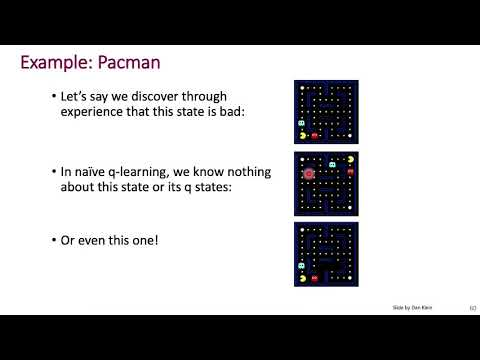

In [ ]:
#@title Video: From Tabular to Deep Q Learning
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ECV5yeigZIg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

In this tutorial, we will study our first "deep" reinforcement learning algorithm: Deep Q-learning. Deep Q-learning is a natural extension of classic Q-learning, which we saw in the last tutorial. Recall that classic Q-learning is a "tabular" method. That is, we keep a table of Q-values for all state and action pairs. What happens if the state space is extremely large or continuous? Well, if the state is represented by a 64x64 image, then the Q table will have $256^{64 * 64} * \text{num_actions}$ entries. This is definitely intractable.

So what do we do? Here's where deep learning comes in to play! We can use a neural network to approximate the Q values. Let's call this neural net Q network. The Q network maps a state and action pair to its Q value. In practice, it takes in a state as input and outputs a vector of Q-values for all actions. We can then create the Q target by taking the max or derive a policy by taking the argmax. Mathematically, let $Q_{\phi}$ be a Q network parametrized by $\phi$. Given a transition tuple, the Q network minimizes the following objective: 

$$\ell(\phi, s, a, r, s') = \left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi}(s', a')\right)\right)^2$$


In other words, we minimize the squared error between the Q estimate and the Q target constructed from the Bellman equation. Convince yourself that an optimal Q network would attain zero loss on all transition tuples. We train the Q network using stochastic gradient descent: 

$$\phi \leftarrow \phi - \alpha \nabla\ell(\phi, s, a, r, s')$$

The "vanilla" DQN algorithm looks very similar to Q-learning: 
```
for n episodes:
    for T steps:
        Forward current state s_t through the Q network to get the Q-values for all actions
        Select an action a_t using epsilon-greedy policy
        Execute a_t in the environment to get reward r and next state s_{t+1}
        Update the Q network by one step of gradient descent
```

In practice, two standard tricks are essential for DQN to work: replay buffer and target network. We will study them in detail. We will also introduce Double DQN, a simple extension that brings significant performance gain. 



Before moving further, let's see the running example for this tutorial. [MinAtar](https://github.com/kenjyoung/MinAtar) is a reduced implemention of five games from the Atari Learning Environment (ALE). The state of each game is provided as a 10x10xN array, where N is number of relevant game objects. For instance, in the game Breakout, there are four objects - the paddle, where the ball is now, where the ball was last frame, and the remaining blocks. Thus the state for the Breakout environment will have the shape 10x10x4. Each game object only occupies a single element in the cell, as can be seen by running the code below.

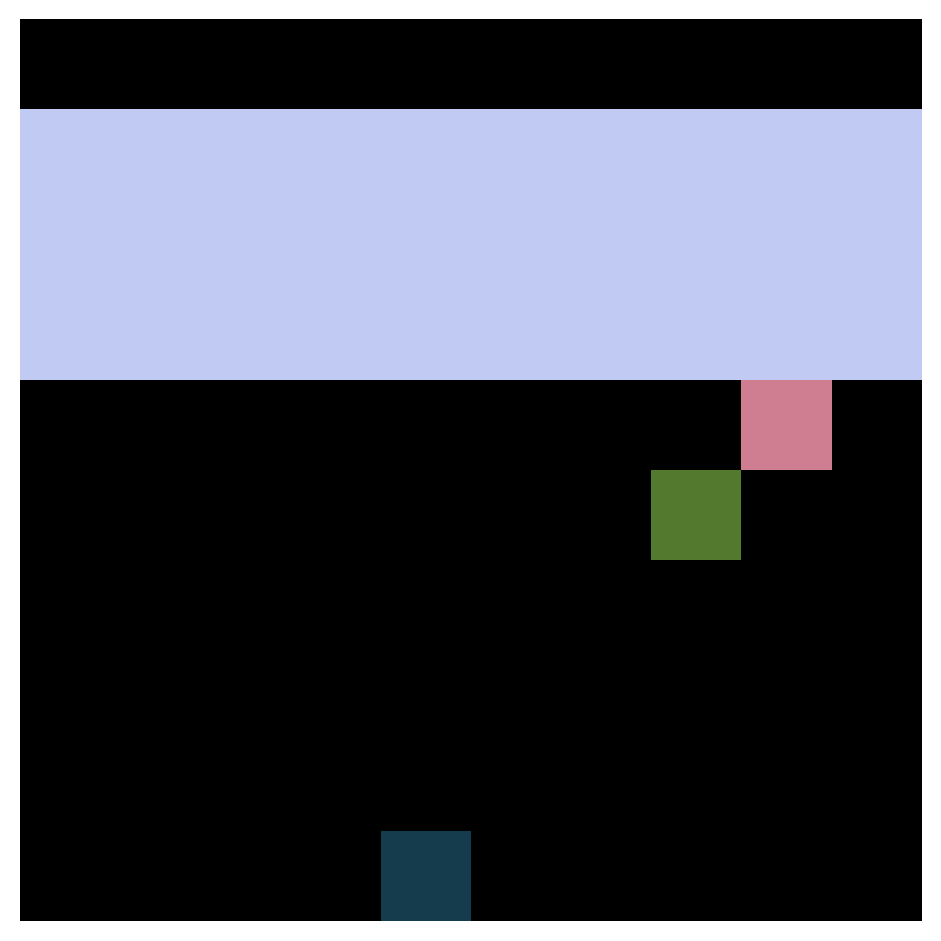

In [ ]:
# crete the Breakout environment
env = Environment('breakout', random_seed=522)
# import matplotlib
# matplotlib.use('TKAgg')
# reset the environment and advance state by two frames to illustrate all channels
env.reset()
env.act(0)
env.act(0)
state = env.state()
plot_minatar_state(state)
plt.show()

While this greatly reduces the complexity of the environment, the range of possible states is still large enough to be intractable for tabular methods. We can no longer represent our Q function as a lookup table, so we instead turn to function approximation methods. And, since the MinAtar state is multiple channels arranged in a grid, we can turn to deep learning solutions and our old friend convolutional neural networks.

In [ ]:
#@markdown What is the number of possible states in the MinAtar Breakout environment?
num_states = "Given 10x10x4 array, the number of possible states is 4 to the power of 100" #@param {type:"string"}


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/num_states.md)

## Exercise 1: Creating the Q network
In this exercise you will be implementing the forward method of a CNN-based PyTorch module for approximating the Q function of a MinAtar environment. The network needs to take in the state of the environment and produce a value prediction for each possible action. The network itself is given as a 2D convolutional layer followed by two fully connected linear layers with ReLU activation functions on all but the last layer.

Note: You will need to flatten the output of the convolutional layer before passing it to the first linear layer.

In [ ]:
class QNetwork(nn.Module):
  def __init__(self, n_channels, n_actions):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=n_channels, out_channels=16,
                          kernel_size=3, stride=1)
    self.fc1 = nn.Linear(in_features=1024, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=n_actions)

  def forward(self, x):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Q network")
    ####################################################################

    # Pass the input through the convnet layer with ReLU activation
    x = F.relu(self.conv(x))
    # Flatten the result while preserving the batch dimension
    x = torch.flatten(x, 1)
    # Pass the result through the first linear layer with ReLU activation
    x = F.relu(self.fc1(x))
    # Finally pass the result through the second linear layer and return
    x = self.fc2(x)
    return x

# Uncomment below to test your module
env = Environment('breakout', random_seed=522)
q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
env.reset()
state = env.state()
# note: phi() transforms the state to make it compatible with PyTorch
q_net(phi(state))

tensor([[ 0.1010, -0.0632, -0.0654, -0.0061,  0.0268, -0.0530]],
       device='cuda:0', grad_fn=<AddmmBackward>)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/W11_Tutorial2_Solution_Ex01.py)

*Example output:*  

```python
tensor([[0.1021, 0.0603, 0.0767, 0.0273, 0.0022, 0.1477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
```

If all went well you should see the Q function output tensor with 6 values, one for each of the 6 actions MinAtar environments allow. Now that you have a working deep neural network approximating your Q function, let's see how well it works on the Breakout task.

First, we are going to define an agent object that is initialized with a policy (always epsilon greedy in these examples), our Q function approximator, and an optimizer for updating our network (always Adam in these examples). On each time step, the `act` method will get called to produce the agent's action given the current state. Once the environment responds to that action, the agent's `train` method gets called with the state, action, reward, discount, next state, and current time step. Just like in the tabular setting, we will start by updating the Q values on every time step.

In [ ]:
class QNetworkAgent: # define agent object
  def __init__(self, policy, q_net, optimizer):
    self.policy = policy # initialized with policy
    self.q_net = q_net # initialized with q function approximator
    self.optimizer = optimizer # initialized with optimizer for updating dqn
  
  def act(self, state): # act method produces agent's action given current state
    return self.policy(self.q_net, state)
  
  # once environment responds, train methord: (frame is current time ste0)
  def train(self, state, action, reward, discount, next_state, frame):
    # Compute our predicted q-value given the state and action from our batch
    q_pred = self.q_net(state).gather(1, action)
    # Now compute the bellman backup
    # First get the best q-value from the next state
    q_target = self.q_net(next_state).max(dim=1)[0].view(-1, 1)
    q_target = reward + discount * q_target.detach()    
    # Compute the MSE loss between the predicted and target values
    loss = F.mse_loss(q_pred, q_target)

    # backpropogation to update the q network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

Now that we have our agent, we are going to have it try to learn the MinAtar Breakout environment. The following code will initialize everything needed to do this, along with your QNetwork module. It will then run the helper function `learn_env` which runs the simulation loop of the agent and environment. `learn_env` will automatically start a new episode whenever the current one terminates and will run for a total of `n_steps` before ending the evaluation. It should take no more than 5 minutes to run 100k steps.

Frame: 10000, reward: [3], steps: [37], time:30.232565879821777
Frame: 20000, reward: [3], steps: [37], time:30.26123547554016
Frame: 30000, reward: [3], steps: [37], time:30.106318712234497
Frame: 40000, reward: [3], steps: [37], time:30.243090867996216
Frame: 50000, reward: [3], steps: [37], time:29.885663747787476
Frame: 60000, reward: [5], steps: [61], time:30.001761198043823
Frame: 70000, reward: [3], steps: [37], time:29.984763860702515
Frame: 80000, reward: [6], steps: [69], time:29.923731327056885
Frame: 90000, reward: [1], steps: [15], time:30.09639000892639
Frame: 100000, reward: [7], steps: [81], time:29.964070081710815


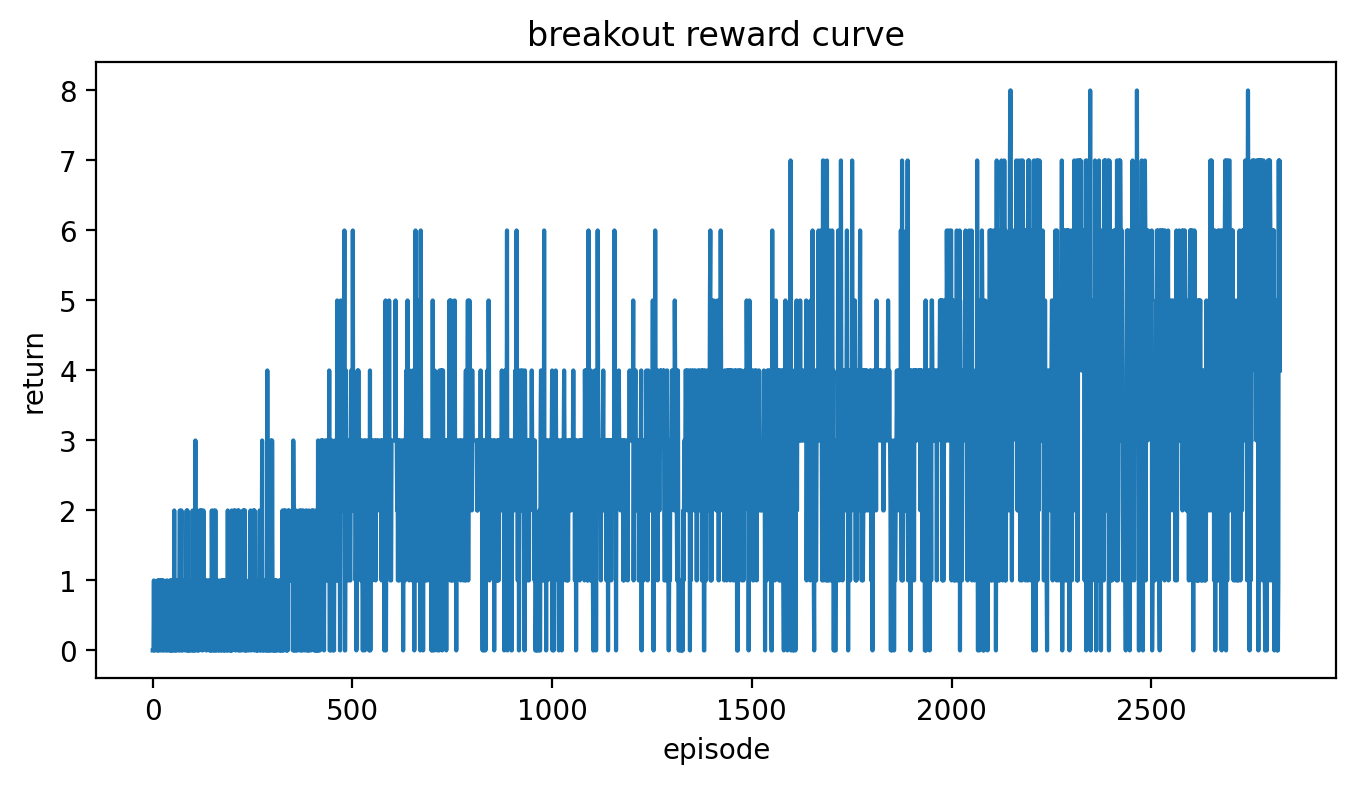

ValueError: ignored

In [ ]:
# initialize... everything!
import time 

tic = time.perf_counter() 
n_steps = 100000
gamma = 0.99
epsilon = 0.1

env = Environment('breakout')
q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
agent = QNetworkAgent(policy, q_net, optimizer)
eps_b_qn = learn_env(env, agent, gamma, n_steps)

plt.figure(figsize=(8, 4))
plt.plot(eps_b_qn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

toc = time.perf_counter()   
print(f'this took {toc-tic:04.f} seconds')



If your QNetwork module is working properly, you should see the agent starting to get a bit better after a few hundred episodes. We can also visualize how our trained agent is actually playing the game by running the following code.

In [ ]:
print(f'this took {toc-tic:0.4f} seconds')
mins = 301/60
mins

this took 301.1295 seconds


5.016666666666667

In [ ]:
# Generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

While this shows some progress on one of tasks in the greatly simplified MinAtar setting, this approach would fare quite poorly on the ALE tasks. The object of the original Deep Q-Network (DQN) paper was to have a general learning solution for all of the games in the ALE. That approach added two key enhancements that enabled this success: using replay buffers and target networks. We will go over each of these in the following sections.

---
# Section 2: Replay Buffer

Video available at https://youtube.com/watch?v=BBBa2mte1Ls


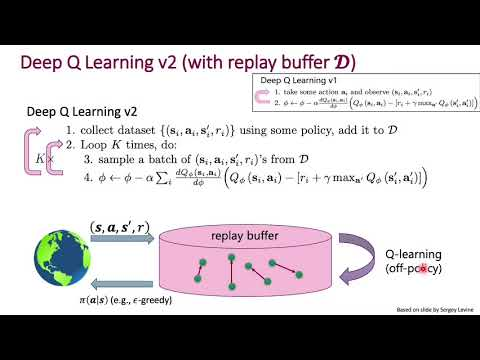

In [ ]:
#@title Video: Experience Replay
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BBBa2mte1Ls", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Deep learning likes to use SGD w/ mini-batches to speed up training. How do we do this in the RL setting? Replay buffer lets us do that by keeping track of past experience which we can then sample. After each environment interaction, we add the transition tuple $(s, a, r, s')$ to the replay buffer. During training, we randomly sample a mini-batch of transition tuples from the replay buffer and use it to update the Q-network. With a replay buffer, the loss of the Q network becomes

$$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi}(s', a')\right)\right)^2$$

where $B$ is a mini-batch of transition tuples. How large should the replay buffer be? If we use only the most recent data, the Q network will overfit; if we use too much experience, the learning can be very slow. This may take some tuning to get right.

In [ ]:
#@markdown What is a key characteristic of Q-learning that allows us to use a replay buffer? Does it make sense to use a replay buffer for SARSA?
characteristic = "Q-learning is off-policy; SARSA is on-policy (so it doesn't make sense). Q-learning's off policy estimates the reward for future actions and appends a value to the new state without having to follow the policy" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/characteristic.md)

## Exercise 2: Creating the replay buffer

In this exercise, you will implement the sampling part of the replay buffer. 

Note that in this implementation we are also storing the discount factor (i.e. $\gamma$) associated with each time step in the replay buffer as well. $\gamma$ is usually fixed so why do this? The answer is that we are actually storing the value $\gamma * (1 - terminal)$ which will be $\gamma$ if the episode is continuing and 0 if it terminated on that step.

In [ ]:
class ReplayBuffer:
  def __init__(self, state_dim, act_dim, buffer_size):
    self.buffer_size = buffer_size
    self.ptr = 0
    self.n_samples = 0

    self.state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)
    self.action = torch.zeros(buffer_size, act_dim, dtype=torch.int64, device=device)
    self.reward = torch.zeros(buffer_size, 1, dtype=torch.float32, device=device)
    self.discount = torch.zeros(buffer_size, 1, dtype=torch.float32, device=device)
    self.next_state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)

  def add(self, state, action, reward, discount, next_state):
    self.state[self.ptr] = state
    self.action[self.ptr] = action
    self.reward[self.ptr] = reward
    self.discount[self.ptr] = discount
    self.next_state[self.ptr] = next_state
    
    if self.n_samples < self.buffer_size:
      self.n_samples += 1

    self.ptr = (self.ptr + 1) % self.buffer_size

  def sample(self, batch_size):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Replay buffer")
    ####################################################################

    # Select batch_size number of sample indices at random from the buffer
    idx = np.random.choice(self.n_samples, batch_size)
    # Using the random indices, assign the corresponding state, action, reward,
    # discount, and next state samples.
    state = self.state[idx]
    action = self.action[idx]
    reward = self.reward[idx]
    discount = self.discount[idx]
    next_state = self.next_state[idx]

    return Batch(state, action, reward, discount, next_state)    

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/W11_Tutorial2_Solution_Ex02.py)

---
# Section 3: Target Network



Video available at https://youtube.com/watch?v=RaIcFiNqP-0


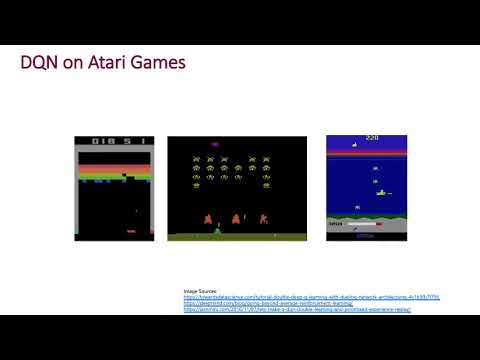

In [ ]:
#@title Video: Target Networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RaIcFiNqP-0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Observe that the Q target is computed using the current Q estimates. Since we update the Q estimates in each training step, we are essentially trying to hit a moving target. This could be mitigated by introducing a target network. Target network is a copy of the Q-network that we update slowly to provide some stability for training. Formally, the Q network loss becomes $$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi_{\text{targ}}}(s', a')\right)\right)^2$$

There are two ways to maintain the target network. One option is to freeze and hard update (full swap) with some training interval. This was the approach used in the original DQN paper. Another way is to use a soft update (polyak averaging), which updates the target every time step with a small weighted average. This was introduced later in the Deep Deterministic Policy Gradient (DDPG) paper to improve training stability, and is the approach we use here.

The following cell defines a soft update function you will use in exercise 3.

In [ ]:
def soft_update_from_to(source, target, tau):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

## Exercise 3: Putting everything together

In this exercise you will adapt the previous QNetworkAgent to take advantage of both the replay buffer for generating batches of samples to train on and the target network for improving training stability. In particular you will focus on implementing most of the `train` method. Feel free to refer back to the original QNetworkAgent `train` method for hints on how to proceed.

The two key changes you will be making from the previous agent are 1) using batches from the replay buffer for training instead of just the direct input and 2) incorporating the target network into the loss function calculation. Recall that the replay buffer returns a `Batch` object, which has state, action, reward, discount, and next_state properties.

There are also other changes to the agent's logic related to the replay buffer. The agent now has a parameter for when it is to start training. If the time step hasn't reached that point, the agent just takes a random action and stores the value in the buffer but doesn't update the q or target networks.

In [ ]:
class DQNAgent:
  def __init__(self, policy, q_net, target_net, optimizer, tau, replay_buffer,
               batch_size, train_start):
    self.policy = policy
    self.q_net = q_net
    self.target_net = target_net
    self.optimizer = optimizer
    self.tau = tau
    self.replay_buffer = replay_buffer
    self.batch_size = batch_size
    self.train_start = train_start
    self.is_waiting = True
    
  def act(self, state):
    if self.is_waiting:
      return torch.randint(6, (1,1))
    return self.policy(self.q_net, state)
  
  def train(self, state, action, reward, discount, next_state, frame):
    # Add the step to our replay buffer
    replay_buffer.add(state, action, reward, discount, next_state)  
    # Don't train if we aren't ready
    if frame < self.train_start:
      return
    elif frame == self.train_start:
      self.is_waiting = False

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("DQN train")
    ####################################################################

    # Sample a batch of steps for training
    batch = self.replay_buffer.sample(self.batch_size)
    # Compute our predicted q-value given the state and action from our batch
    q_pred = self.q_net(batch.state).gather(1, batch.action)
    # Now compute the bellman backup using the target network
    # First get the q-values from the next state and best action
    q_target = self.target_net(batch.next_state).max(1)[0].view(-1,1)
    # Next multiply by the discount and add the reward signal
    q_target = q_target.detach() * batch.discount + batch.reward
    # Compute the MSE loss between the predicted and target values, then average
    # over the batch
    loss = F.mse_loss(q_pred, q_target).mean()

    # backpropogation to update the q-network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # soft update target network with the updated q-network
    soft_update_from_to(self.q_net, self.target_net, self.tau)


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/W11_Tutorial2_Solution_Ex03.py)

Now that we have our DQN agent, let's set everything up and see how well it learns the Breakout environment. 100k steps should run in under 8 minutes.

In [ ]:
n_steps = 100000
gamma = 0.99
epsilon = 0.1
tau = 1e-2  # how slowly we update the target network 

env = Environment('breakout')
state_dim = (env.n_channels, 10, 10)
act_dim = 1
buffer_size = 100000
batch_size = 64
train_start = 5000

q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
target_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(state_dim, act_dim, buffer_size)
agent = DQNAgent(policy, q_net, target_net, optimizer, tau, replay_buffer,
                 batch_size, train_start)
eps_b_dqn = learn_env(env, agent, gamma, n_steps)

Frame: 10000, reward: [0], steps: [5], time:24.749348402023315
Frame: 20000, reward: [2], steps: [25], time:47.32521939277649
Frame: 30000, reward: [7], steps: [83], time:47.76601028442383
Frame: 40000, reward: [7], steps: [81], time:47.86147117614746
Frame: 50000, reward: [9], steps: [103], time:47.35978984832764
Frame: 60000, reward: [7], steps: [81], time:47.72876453399658
Frame: 70000, reward: [9], steps: [107], time:47.37215304374695
Frame: 80000, reward: [1], steps: [15], time:46.87480330467224
Frame: 90000, reward: [5], steps: [59], time:47.78935432434082
Frame: 100000, reward: [5], steps: [59], time:47.829896688461304


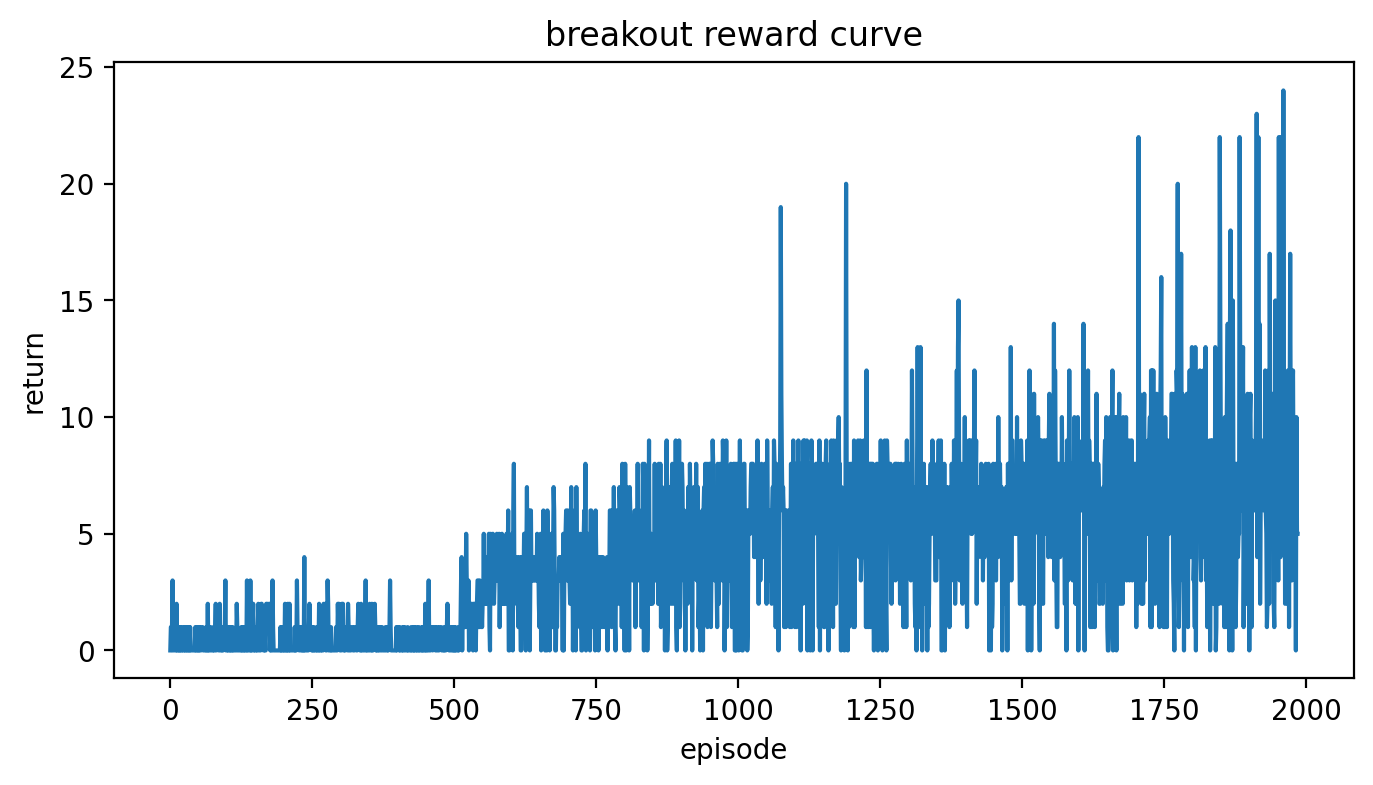

In [ ]:
#@markdown Run cell to plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(eps_b_dqn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

In [ ]:
#@markdown Run cell to generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

You should see more consistent and stable returns over time with the DQNAgent vs the QNetworkAgent. Except for the beginning where the agent doesn't really learn much until around 500 episodes or so, which is related to that `train_start` parameter.

In [ ]:
#@markdown What is the purpose of delaying the start of training while choosing random actions?
purpose = "get a distribution of outcomes before sampling to improve stability" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/purpose.md)

---
# Section 4: Double Q-Learning





Video available at https://youtube.com/watch?v=Lb5ADHnRQV8


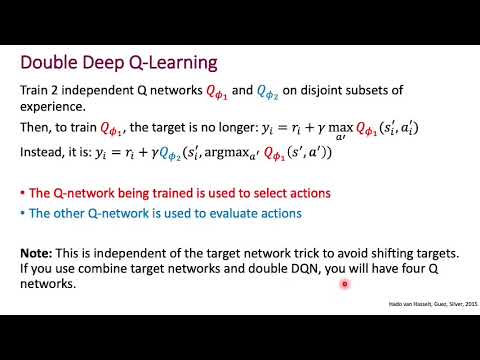

In [ ]:
#@title Video: Double DQN
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Lb5ADHnRQV8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

A problem with DQN is that the max operator on the target network can result in overestimated values because we are mixing the selection and evaluation of actions in the same network. Double DQN decouples this by making the action selection of the target network based on the q-network instead. This boils down to a very simple change to the Q network loss:

$$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma Q_{\phi_{\text{targ}}}\left(s', \arg\max_{a'}Q_{\phi}(s', a')\right)\right)\right)^2$$


## Exercise 4: Double DQN

In the following exercise, you will create the training method for the DoubleDQN agent. Since we are only updating the `train` from the original DQNAgent, you will work from a subclass of that agent. This is a helpful design pattern if you want to only change one part of an existing agent while keeping the rest of its behavior intact. In the case of DoubleDQN, you are only changing how the target Q value is determined.


In [ ]:
class DoubleDQNAgent(DQNAgent):
  def train(self, state, action, reward, discount, next_state, frame):
    # Add the step to our replay buffer
    replay_buffer.add(state, action, reward, discount, next_state)  
    # Don't train if we aren't ready
    if frame < self.train_start:
      return
    elif frame == self.train_start:
      self.is_waiting = False
    
    # Sample a batch of steps for training
    batch = self.replay_buffer.sample(self.batch_size)
    
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Double DQN")
    ####################################################################
    
   # Compute our predicted q-value given the state and action from our batch
    q_pred = self.q_net(batch.state).gather(1, batch.action)
    # Now compute the bellman backup using the target network and q-network
    # First get the best actions from the q-network and the next state
    max_acts = self.q_net(batch.next_state).argmax(dim=1).view(-1,1)
    # Next get the q-values from the target network using these actions
    # q_target = self.target_net(batch.next_state)[range(len(max_acts)), max_acts].view(-1, 1)
    q_target = self.target_net(batch.next_state).gather(1, max_acts)
    # Now multiply by the discount and add the reward signal
    q_target = batch.reward + batch.discount * q_target.detach()
    # Compute the MSE loss between the predicted and target values, then average
    # over the batch
    loss = F.mse_loss(q_pred, q_target).mean()  

    # backpropogation to update the q network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # soft update target network with the updated q-network
    soft_update_from_to(self.q_net, self.target_net, self.tau)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/W11_Tutorial2_Solution_Ex04.py)

Now that we have our DoubleDQNAgent, let's see how it fares on the Breakout envionment. 100k steps should run in under 10 minutes.

In [ ]:
n_steps = 100000
gamma = 0.99
epsilon = 0.1
tau = 1e-2

env = Environment('breakout')
state_dim = (env.n_channels, 10, 10)
act_dim = 1
buffer_size = 100000
batch_size = 64
train_start = 5000

q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
target_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(state_dim, act_dim, buffer_size)

agent = DoubleDQNAgent(policy, q_net, target_net, optimizer, tau, replay_buffer,
                       batch_size, train_start)
eps_b_ddqn = learn_env(env, agent, gamma, n_steps)

Frame: 10000, reward: [1], steps: [15], time:32.95559525489807
Frame: 20000, reward: [7], steps: [83], time:63.26201939582825
Frame: 30000, reward: [0], steps: [5], time:63.162638664245605
Frame: 40000, reward: [1], steps: [15], time:63.12808632850647
Frame: 50000, reward: [6], steps: [69], time:62.81507420539856
Frame: 60000, reward: [6], steps: [71], time:61.56764197349548
Frame: 70000, reward: [12], steps: [139], time:61.17271685600281
Frame: 80000, reward: [20], steps: [153], time:61.196959495544434
Frame: 90000, reward: [18], steps: [203], time:61.3111937046051
Frame: 100000, reward: [0], steps: [5], time:61.246155738830566


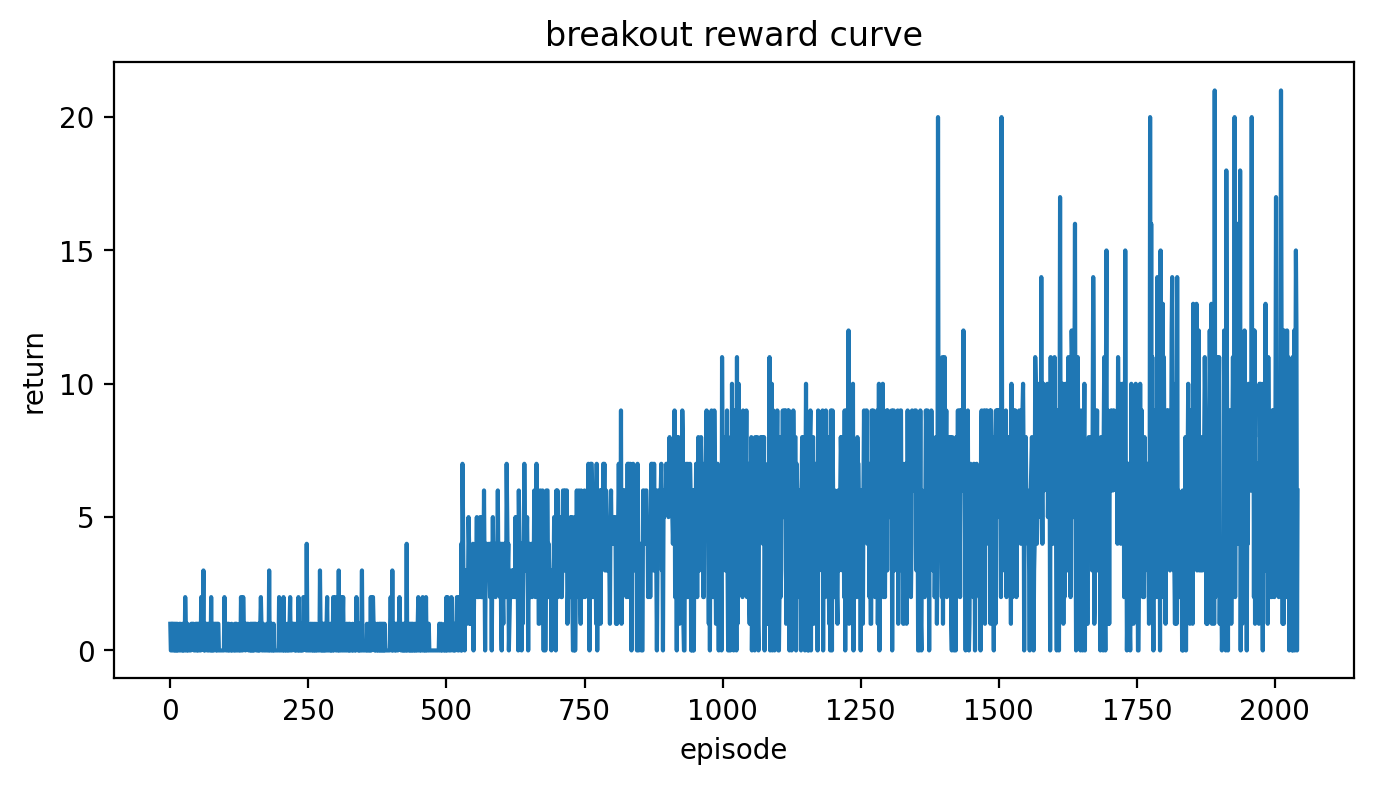

In [ ]:
#@markdown Run cell to plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(eps_b_ddqn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

In [ ]:
#@markdown Run cell to generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

We should see similar performance initially to that of the DQNAgent, but a big jump in scores after around 1300 episodes. You may have noticed however that this came at a performance hit in terms of training speed over the DQNAgent, which in turn was slower to train than the QNetworkAgent.

In [ ]:
#@markdown What is the source of the slowdown per 10,000 steps across the three different agents?
slowdown = "" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W11_DeepRL/solutions/slowdown.md)

---
# Section 5: Extending to Continuous Actions



In [ ]:
#@title Video: Deep Deterministic Policy Gradients
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ljHwbY9QrJU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

So far, we've seen a few successes of DQN on the MinAtar environment. Can we use DQN to solve all RL problems? Unfortunately, one glaring assumption of DQN is discrete actions. When computing the Q target or deriving the greedy policy, we need to take the argmax of Q-values over actions. If the action space is continuous, then searching for the argmax is a nontrivial optimization problem. Since we need to perform this search in each step of training and inference, the computation time becomes intractable.

[Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) extends DQN to continuous actions by introducing an actor network. The goal of the actor network is to predict the action that maximizes the Q-value given the current state. This effectively amortizes the argmax search into training. Concretely, let $\mu_{\theta}$ be an actor network paramterized by $\theta$. The actor's objective is to output an action that maximizes its Q-value: $$\max_{\theta} E_{s \sim D}\left[Q_{\phi}(s, \mu_{\theta}(s))\right]$$ and the Q network's loss becomes $$L(\phi, D) = E_{(s, a, r, s') \sim D}\left[\left(Q_\phi(s, a) - (r + \gamma Q(s', \mu_{\theta}(s'))\right)^2\right] $$ where we have replaced $\max_{a'}Q(s', a')$ with $Q(s', \mu_\theta(s'))$. During training, we optimize the actor network and the Q network jointly using gradient descent.

You may have noticed that the actor network looks like a policy. Indeed, DDPG is belongs to a family of RL algorithms called actor-critic algorithms. An actor-critic algorithm typically consists of a policy and a value function that are jointly optimized. The value function guides policy learning, and inference is done with the policy alone. We will discuss policy optimization and actor-critic algorithms in greater detail next week. 


---
# Response and Feedback forms

In [ ]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame

#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: learning_from_previous_tutorial;
except NameError: learning_from_previous_tutorial = ""
try: num_states;
except NameError: num_states = ""
try: characteristic;
except NameError: characteristic = ""
try: purpose;
except NameError: purpose = ""
try: slowdown;
except NameError: slowdown = ""

times = np.array([t1,t2,t3,t4,t5,t6])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "learning_from_previous_tutorial": learning_from_previous_tutorial,
          "num_states": num_states,
          "characteristic": characteristic,
          "purpose": purpose,
          "slowdown": slowdown,
          "cumulative_times": times}

src = "https://airtable.com/embed/shr9rdodIrMvW4OuG?"


# now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))